<a href="https://colab.research.google.com/github/MittalNeha/retinopathy-kaggle/blob/master/EfficientNet_multilabel_smallBatch_olddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import (Activation, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,
                          Dense, BatchNormalization, GlobalAveragePooling2D)
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.layers import LeakyReLU

from keras.applications.resnet50 import ResNet50
# from keras.applications.res

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from keras import metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils import class_weight, shuffle
import cv2
from keras import backend as K
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [0]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    tf.set_random_seed(seed)
#     session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#     sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#     K.set_session(sess)

# Make the augmentation sequence deterministic
#     aug.seed(seed)
    
seed_everything(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def get_kaggle_data():
  os.environ['KAGGLE_USERNAME'] = "mittalneha"
  os.environ['KAGGLE_KEY'] = "59ec3f992f5fb4b510bebd8dea889381"
  
  !kaggle competitions download -c aptos2019-blindness-detection
  
  !mkdir kaggle-data
  !mv sample_submission.csv kaggle-data/
  !mv test.csv kaggle-data/

  !unzip test_images.zip -d kaggle-data/test_images
  !rm test_images.zip
  !rm train_images.zip

  !cp /content/gdrive/My\ Drive/Retinopathy/data/aug_train_images.zip .
  !unzip aug_train_images.zip -d kaggle-data/
  !rm aug_train_images.zip
  
  !cp /content/gdrive/My\ Drive/Retinopathy/data/aug_train.csv kaggle-data/
  !mv aug_train.csv kaggle-data/
  
  !cp /content/gdrive/My\ Drive/Retinopathy/data/old_train_images_456.zip .
  !unzip old_train_images_456.zip -d kaggle-data/
  !rm old_train_images_456.zip
  
  !cp /content/gdrive/My\ Drive/Retinopathy/data/trainLabels.csv kaggle-data/
  !mv trainLabels.csv kaggle-data/  
  
  
  !kaggle datasets download -d ratthachat/efficientnet-keras-weights-b0b5
  !cp /content/gdrive/My\ Drive/Retinopathy/data/efficientnet-master.zip .
  !unzip efficientnet-keras-weights-b0b5 -d kaggle-data/efficientnets-weights/
  !unzip efficientnet-master.zip
  

In [0]:
data_dir = "kaggle-data"
get_kaggle_data()

100% 8.01G/8.01G [01:43<00:00, 92.1MB/s]
100% 8.01G/8.01G [01:43<00:00, 83.5MB/s]
 99% 1.49G/1.50G [00:17<00:00, 75.5MB/s]
100% 1.50G/1.50G [00:17<00:00, 93.8MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 47.8MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 28.0MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 27.5MB/s]
Archive:  test_images.zip
  inflating: kaggle-data/test_images/270a532df702.png  
  inflating: kaggle-data/test_images/86fd5df366b2.png  
  inflating: kaggle-data/test_images/72dd7ca97f55.png  
  inflating: kaggle-data/test_images/ec8f3ec97245.png  
  inflating: kaggle-data/test_images/b3db392f5ee8.png  
  inflating: kaggle-data/test_images/c71728f9535b.png  
  inflating: kaggle-data/test_images/c7c003cdaaba.png  
  inflating: kaggle-data/test_images/67b614d32bcc.png  
  inflating: kaggle-data/test_images/e982c6b5b726.png  
  inflating: kaggle-data/test_images/e2fdc91493f4.png  
  inflating: kaggle-data/test_i

In [0]:
# sys.path.remove('/content/efficientnet-master')

In [0]:
# !pip install efficientnet-master/

In [0]:
import sys
sys.path.append(os.path.abspath('efficientnet-master/'))
import efficientnet.keras as efn 

In [0]:
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 456
NUM_CLASSES = 5

In [0]:
df_train = pd.read_csv('kaggle-data/aug_train.csv')
df_test = pd.read_csv('kaggle-data/test.csv')
df_old = pd.read_csv('kaggle-data/trainLabels.csv')

df_train.columns = ['id_code', 'diagnosis']
df_old.columns = ['id_code', 'diagnosis']

#removing images that had bad contrast
df_old = df_old[df_old.id_code != '1986_left']
df_old = df_old[df_old.id_code != '34689_left']

df_train['id_code'] = 'kaggle-data/aug_train_images/' + df_train['id_code'].astype(str) + ".png"
df_old['id_code'] = 'kaggle-data/old_train_images_456/' + df_old['id_code'].astype(str) + ".jpeg"

train_df = pd.concat([df_train,df_old]).reset_index(drop=True)
train_df.head()

In [0]:
train_df['diagnosis'].hist()

In [10]:
def get_label(diagnosis):
  return [i for i in range(diagnosis + 1)]
#     return ','.join([str(i+1) for i in range(diagnosis + 1)])
train_df['label'] = train_df.diagnosis.apply(get_label)
train_df.head()

,id_code,diagnosis,label
0,000c1434d8d7_0,2,"[0, 1, 2]"
1,001639a390f0,4,"[0, 1, 2, 3, 4]"
2,001639a390f0_0,4,"[0, 1, 2, 3, 4]"
3,001639a390f0_1,4,"[0, 1, 2, 3, 4]"
4,001639a390f0_2,4,"[0, 1, 2, 3, 4]"


In [0]:
mlb = MultiLabelBinarizer(classes=[0,1,2,3,4])
# labels = [(1,2), (1,), (1,2)]

# y = mlb.fit_transform(y)
# mlb.fit_transform(labels)
# mlb.fit_transform(list(y[i]) for i in range(0,len(y)))
# yy = mlb.fit_transform(df_train['diagnosis'])
# mlb.classes_

In [12]:
y = train_df['label']
y = mlb.fit_transform(y)
x = train_df['id_code']


x, y = shuffle(x, y, random_state=8)
# y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(7785,)
(7785, 5)
(1374,)
(1374, 5)


In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Flipud(0.5)
],random_order=True)

In [0]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread(sample)
#             img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread(sample)
#             img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

# LR Finder

In [0]:
from keras.callbacks import LambdaCallback
import math

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        
          
        if math.isnan(loss) or loss > self.best_loss *100:
            self.model.stop_training = True
            print("Stop Training {}, best_loss{}, lr{}".format(loss, self.best_loss, lr))
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)
#         print("Current Learning Rate{}".format(lr))

    def find(self, train_gen, start_lr, end_lr, batch_size=64, epochs=1, steps=1):
        num_batches = epochs * steps
#         x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)
        print(self.lr_mult)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

#         self.model.fit(x_train, y_train,
#                         batch_size=batch_size, epochs=epochs,
#                         callbacks=[callback])
#         print("Calling fit")
        self.model.fit_generator(
                  train_gen,
                  steps_per_epoch=steps,
                  
                  epochs=epochs,
                  verbose=1,
                  workers=1, use_multiprocessing=False,
                  callbacks=[callback])
    
#         print("After fit")

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)
        print("Set lr to {}".format(original_lr))

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives
    
    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)
        
    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [0]:
input_tensor = Input(shape=(SIZE,SIZE,3))
base_model = efn.EfficientNetB5(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
base_model.summary()


In [47]:
base_model.layers[2]

In [0]:
import keras

In [51]:
base_model.layers[2].ins keras.layers.normalization.BatchNormalization

False

In [53]:
isinstance(base_model.layers[1], keras.layers.normalization.BatchNormalization)

False

In [0]:
for i, layer in enumerate(base_model.layers):
  print(layer.name)
   if "batch_normalization" in layer.name:
#         print('batch_norm found in ', i)
#         effnet.layers[i] = GroupNormalization(groups=2, axis=-1, epsilon=0.1)

The image Size is High, hence going OOM
- will use smaller match size
- Its recommended to use Group Normalization for smaller batch.

In [0]:
# https://github.com/titu1994/Keras-Group-Normalization/blob/master/group_norm.py
  
from keras.engine import Layer, InputSpec
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K


class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
def create_model(input_shape, n_out, model_weights):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB5(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')
    
    for i, layer in enumerate(base_model.layers):
      if isinstance(layer, keras.layers.normalization.BatchNormalization):
        print('batch_norm found in ', i)
        base_model.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)
#         base_model.layers[i] = GroupNormalization(groups=2, axis=-1, epsilon=0.1)
        
#     x = GlobalAveragePooling2D()(base_model.output)
    
    classifier = Sequential()
    classifier.add(GlobalAveragePooling2D())
#     classifier.add(Flatten())   
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(1024))
#     classifier.add(BatchNormalization())
#     classifier.add(Activation('relu'))
    classifier.add(LeakyReLU())
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(n_out, activation='sigmoid', name='final_output'))
    #Use sigmoid for multilabel and softmax for single label classification
#     final_output = Dense(n_out, activation='sigmoid', name='final_output')(classifier.output)
    base_model.summary
    model = Sequential([
      base_model, 
      classifier
    ])
    
#     model = Model(input_tensor, final_output)
#     model.load_weights(model_weights)
    
    return model

In [0]:
base_model.summary()

In [0]:
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')

In [0]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='kaggle-data/resnet50/Resnet50_bestqwk.h5')
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
lr_finder = LRFinder(model)

def determineLearningRate():    
    batch_size = 4
    num_classes = NUM_CLASSES
    epochs = 4
    
    train_generator = My_Generator(train_x, train_y, batch_size, is_train=True)
    steps = np.ceil(float(len(train_x)) / float(batch_size))
    print(steps)
    lr_finder.find(train_generator, start_lr=0.00001, end_lr=0.1, batch_size=batch_size, epochs=epochs, steps=steps)
    lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
    plt.show()
    return model
determineLearningRate()

lr = lr_finder.get_best_lr(sma=10)
print('Best Learning Rate: {}'.format(lr))

In [0]:
!mkdir 'kaggle-data/model'

In [63]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 4
checkpoint = ModelCheckpoint('kaggle-data/model/EffNetB5-{epoch:02d}-{val_acc:.4f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# checkpoint = ModelCheckpoint('kaggle-data/model/xception-model.h5', verbose=1, monitor='val_acc',
#                               save_best_only=True, save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)

csv_logger = CSVLogger(filename='kaggle-data/model/training_log.csv',
                       separator=',',
                       append=True)
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]

# train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=True, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')

batch_norm found in  2
batch_norm found in  5
batch_norm found in  13
batch_norm found in  15
batch_norm found in  23
batch_norm found in  27
batch_norm found in  35
batch_norm found in  39
batch_norm found in  42
batch_norm found in  50
batch_norm found in  52
batch_norm found in  55
batch_norm found in  63
batch_norm found in  67
batch_norm found in  70
batch_norm found in  78
batch_norm found in  82
batch_norm found in  85
batch_norm found in  93
batch_norm found in  97
batch_norm found in  100
batch_norm found in  108
batch_norm found in  112
batch_norm found in  115
batch_norm found in  123
batch_norm found in  125
batch_norm found in  128
batch_norm found in  136
batch_norm found in  140
batch_norm found in  143
batch_norm found in  151
batch_norm found in  155
batch_norm found in  158
batch_norm found in  166
batch_norm found in  170
batch_norm found in  173
batch_norm found in  181
batch_norm found in  185
batch_norm found in  188
batch_norm found in  196
batch_norm found in  1

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
sequential_6 (Sequential)    (None, 5)                 2103301   
Total params: 30,616,821
Trainable params: 30,444,085
Non-trainable params: 172,736
_________________________________________________________________


In [0]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [0]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            
            def get_pred(y):
#                 print(y[0])
                y_pred = y > 0.5
#                 print(y_pred[0])
                y_pred = y_pred.astype(int).sum(axis=1) - 1
#                 print(y_pred.reshape(-1))
                return y_pred.reshape(-1)
                
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(get_pred(self.y_val),
                                      get_pred(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('kaggle-data/model/EffNet_qwk-{0:02d}-{1:.4f}.h5'.format(epoch, score))

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [27]:
train_y.shape

(7785, 5)

In [66]:
# train all layers
for layer in model.layers:
    layer.trainable = True

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy',
#              loss=kappa_loss,
            optimizer=Adam(lr=1e-3),
            metrics=['accuracy'])
#, metrics=['accuracy']
history = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 1/10
1947/1947 [==============================] - 1738s 893ms/step - loss: 0.3654 - acc: 0.6776 - val_loss: 0.2277 - val_acc: 0.9087

Epoch 00001: val_loss improved from inf to 0.22771, saving model to kaggle-data/model/EffNetB5-01-0.9087.h5
344/344 [==============================] - 89s 260ms/step

 epoch: 1 - QWK_score: 0.834590 

saving checkpoint:  0.8345896474821545
Epoch 2/10
1947/1947 [==============================] - 1655s 850ms/step - loss: 0.3023 - acc: 0.7024 - val_loss: 0.2857 - val_acc: 0.8689

Epoch 00002: val_loss did not improve from 0.22771
344/344 [==============================] - 69s 201ms/step

 epoch: 2 - QWK_score: 0.698145 

Epoch 3/10
1947/1947 [==============================] - 1654s 849ms/step - loss: 0.2903 - acc: 0.6991 - val_loss: 0.2068 - val_acc: 0.9192

Epoch 00003: val_loss improved from 0.22771 to 0.20677, saving model to kaggle-data/model/EffNetB5-03-0.9192.h5
344/344 [==============================] - 69s 201ms/step

 epoch: 3 - QWK_score: 0.

KeyboardInterrupt: ignored

In [0]:
lr = K.get_value(model.optimizer.lr)
K.set_value(model.optimizer.lr, lr/2)

In [0]:
K.get_value(model.optimizer.lr)

0.00025

In [0]:
epochs = 30
history2 = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    initial_epoch=15,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Load the best model

In [0]:
model.load_

# Evaluate Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
all_scores = []
for i, name in tqdm(enumerate(valid_x)):
  path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
  image = cv2.imread(path)
  image = cv2.resize(image, (SIZE, SIZE))

  scores = model.evaluate((image[np.newaxis])/255, np.reshape(valid_y[i], (1,5)), verbose=0)
  all_scores.append(scores)

mean = np.mean(all_scores, axis=0)
sd = np.std(all_scores, axis=0)
print("Loss:    %.2f%% (+/- %.2f%%)" % (mean[0], sd[0]))
print("Accuracy:%.2f%% (+/- %.2f%%)" % (mean[1], sd[1]))

1374it [01:07, 20.22it/s]

Loss:    3.80% (+/- 3.01%)
Accuracy:1.00% (+/- 0.00%)


In [0]:
history2.history


NameError: ignored

In [0]:
def get_pred(y):
  y_pred = y > 0.5
  y_pred = y_pred.astype(int).sum(axis=1) - 1
  return y_pred.reshape(-1)

def check_model(hist, model):
  
  #Plot the curves
  N = len(hist.history['loss'])

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
  
 
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["acc"], label="train_acc")
  plt.plot(np.arange(0, N), hist.history["val_acc"], label="val_acc")
  plt.title("Training Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  
  plt.figure()
  plt.plot(np.arange(0, N), qwk.history, label="kappa_score")
  plt.title("Kappa score on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("kappa")
  plt.legend(loc="lower left")
  
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["lr"], label="learning_rate")
 
  plt.title("Learning Rate on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("LR")
  plt.legend(loc="lower left")
  
  
  #confusion matrix
  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = get_pred(score_predict)
#       print('Predict {}-->{}'.format(score_predict, label_predict))
#       label_predict = np.argmax(score_predict)
      
      preds.append(label_predict)

#   valid_labels = np.argmax(valid_y, axis=-1)
  valid_labels = get_pred(valid_y)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

1374it [01:30, 15.21it/s]


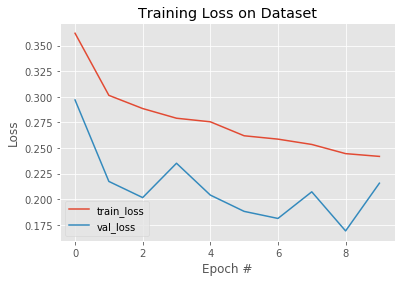

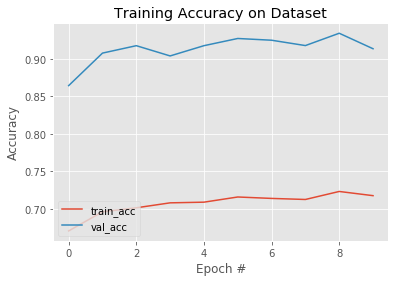

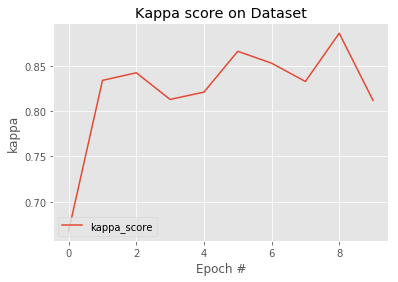

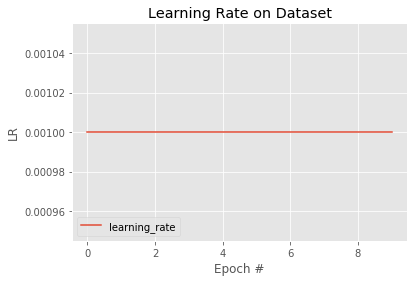

<Figure size 432x288 with 0 Axes>

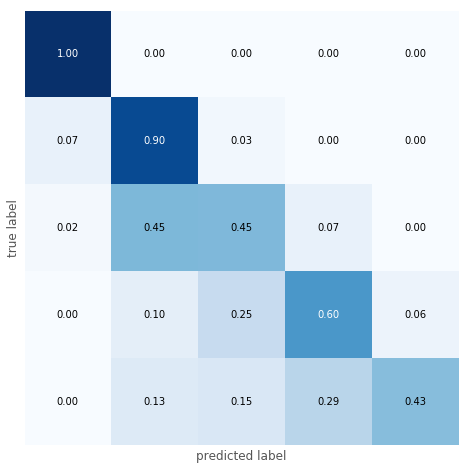

In [30]:
check_model(history, model)

In [0]:
  def get_pred(y):
    y_pred = y > 0.5
    mask = y_pred == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = get_pred(score_predict)
#       print('Predict {}-->{}'.format(score_predict, label_predict))
#       label_predict = np.argmax(score_predict)
      
      preds.append(label_predict)

#   valid_labels = np.argmax(valid_y, axis=-1)
  valid_labels = get_pred(valid_y)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

In [0]:
qwk.history

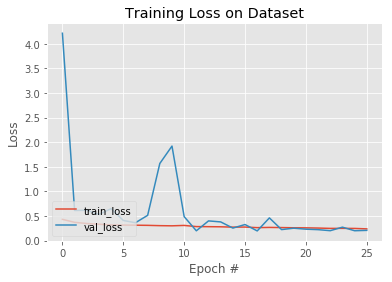

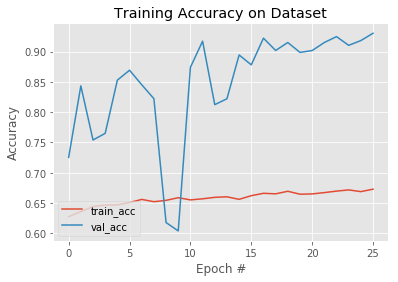

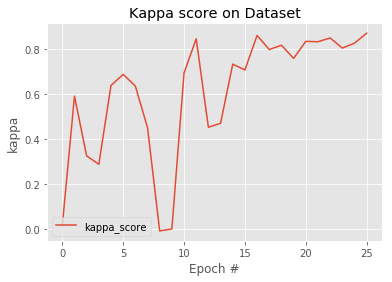

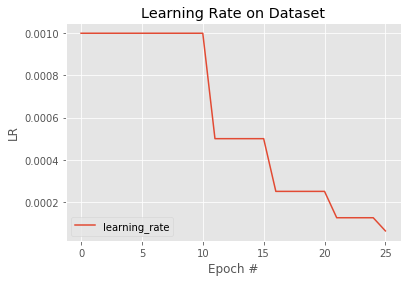

In [0]:
check_model(history, model)

1374it [01:07, 20.37it/s]


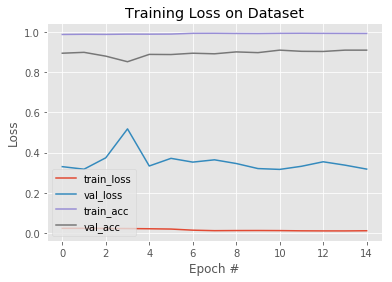

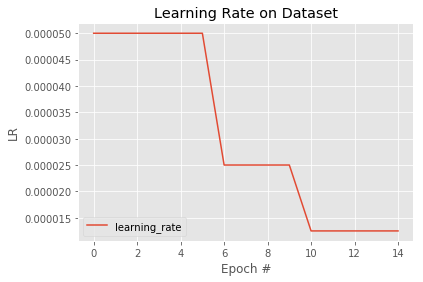

<Figure size 432x288 with 0 Axes>

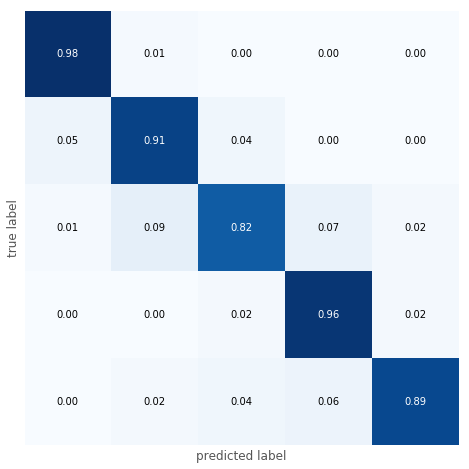

In [0]:
check_model(history2, model)

# Save Model

In [67]:
%cd kaggle-data/model

/content/kaggle-data/model


In [68]:
!zip EffNet_multi_456_3.zip EffNetB5-05-0.9250.h5
!cp EffNet_multi_456_3.zip /content/gdrive/My\ Drive/Colab\ Notebooks/

  adding: EffNetB5-05-0.9250.h5 (deflated 7%)


In [33]:
%cd ../../

/content


# Compare models

In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/resnet50_aug3.zip .
!mkdir resnet50_aug3
!unzip resnet50_aug3.zip -d resnet50_aug3

Archive:  resnet50_aug3.zip
  inflating: resnet50_aug3/Resnet50-09-0.8952.h5  
  inflating: resnet50_aug3/Resnet50_qwk-23-0.9533.h5  


In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/resnet50_aug4.zip .
!mkdir resnet50_aug4
!unzip resnet50_aug4.zip -d resnet50_aug4

Archive:  resnet50_aug4.zip
  inflating: resnet50_aug4/Resnet50_qwk-29-0.9558.h5  


In [0]:
def preprocess_image(img):
  
  if img.shape[2] ==1:
    img = np.dstack([img, img, img])

  img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret, img2 = cv2.threshold(img1, 10, 255, cv2.THRESH_BINARY)
  points = np.argwhere(img2!=0)
  points = np.fliplr(points)
  x, y, w, h = cv2.boundingRect(points)

  color_cropped = img[y:y+h, x:x+w]

  clahe = cv2.createCLAHE(clipLimit=4.0)

  lab = cv2.cvtColor(color_cropped, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab_planes[1] = clahe.apply(lab_planes[1])
  lab_planes[2] = clahe.apply(lab_planes[2])
  
  out = cv2.merge(lab_planes)
  img3 = cv2.cvtColor(out, cv2.COLOR_LAB2BGR)
  
  img = cv2.resize(img3, (SIZE,SIZE), cv2.INTER_AREA)
  
#   img = img.astype(np.float32)/255
  
  return img

In [0]:
train, val = train_test_split(df_train, test_size=0.4)
train_data = train

In [0]:
train.head()

,id_code,diagnosis
7906,d9e58e4d8689,0
5884,a2ddabee14e9,4
191,05a5183c92d0_0,1
7120,c3cd0200df79_1,3
7202,c613db1cab27,2


In [0]:
model1 = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights="resnet50_aug3/Resnet50-09-0.8952.h5")
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(1e-3))

model2 = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='resnet50_aug4/Resnet50_qwk-29-0.9558.h5')
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(1e-3))

W0807 06:26:48.074534 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 06:26:48.142511 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 06:26:48.170713 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0807 06:26:48.221229 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 06:26:48.222414

In [0]:
#Evaluate with train data itself
train_img = []
train_labels = []

for idx, row in train_data.iterrows():
    path = 'kaggle-data/aug_train_images/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = preprocess_image(img)

    label = to_categorical(int(row['diagnosis']), num_classes=5)
    train_img.append(img)
    train_labels.append(label)
    
train_img = np.array(train_img)
train_labels = np.array(train_labels)

## Evaluate First Model

In [0]:
eval_loss1, eval_score1 = model1.evaluate(train_img, train_labels, batch_size=16)
print("Loss on test set: ", eval_loss1)
print("Accuracy on test set: ", eval_score1)

5495/5495 [==============================] - 96s 18ms/step
Loss on test set:  7.650551852624561
Accuracy on test set:  0.2043676069316482


In [0]:
#Evaluate with train data itself
predicted1 = []
# train_labels = []

for idx, row in train_data.iterrows():
    path = 'kaggle-data/aug_train_images/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = preprocess_image(img)

    label = to_categorical(int(row['diagnosis']), num_classes=5)
    score_predict = model1.predict((img[np.newaxis])/255)
    label_predict = np.argmax(score_predict)
    predicted1.append(str(label_predict))
    

In [0]:
cm  = confusion_matrix(orig_train_labels, predicted1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()

ValueError: ignored

In [0]:
preds1 = model1.predict(train_img, batch_size=16)
preds1 = np.argmax(preds1, axis=-1)

# Original labels
orig_train_labels = np.argmax(train_labels, axis=-1)

## Confusion Matrix

<Figure size 432x288 with 0 Axes>

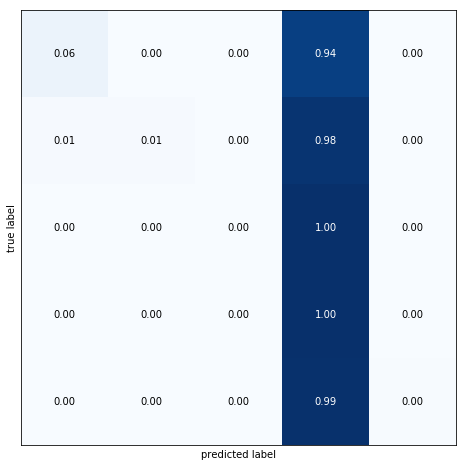

In [0]:
cm  = confusion_matrix(orig_train_labels, preds1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()

## Evaluate second Model

In [0]:
eval_loss2, eval_score2 = model2.evaluate(train_img, train_labels, batch_size=16)
print("Loss on test set: ", eval_loss2)
print("Accuracy on test set: ", eval_score2)

5495/5495 [==============================] - 91s 17ms/step
Loss on test set:  7.940974250460235
Accuracy on test set:  0.26223839856040165


In [0]:
preds2 = model2.predict(train_img, batch_size=16)
preds2 = np.argmax(preds2, axis=-1)

# Original labels
# orig_train_labels = np.argmax(train_labels, axis=-1)

<Figure size 432x288 with 0 Axes>

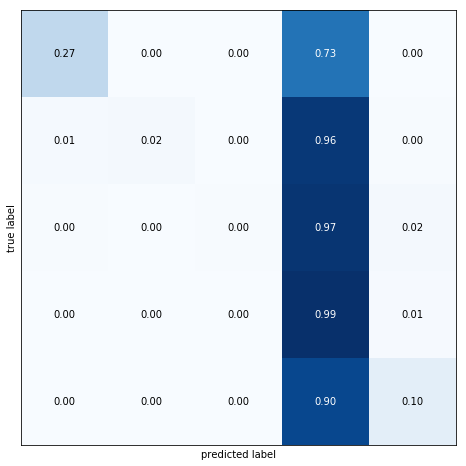

In [0]:
cm  = confusion_matrix(orig_train_labels, preds2)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()